# Blue print for calculating power spectrum for ENSO variability

This code calculates the power spectrum of monthly-mean Nino3.4 SST variability. Its purpose is to document different approaches that I tested based on the discrete fourier transformation and the periodogram. Thr original motivation for doing comes from the work on a cloud review paper in March 2020.

As for the data, monthly-mean SST data averaged over the Nino 3.4 region (190E-240E and 5S-5N) is used from the control simulation of Raedel et al., 2016, Nature Geoscience, Amplification of El Niño by cloud longwave
coupling to atmospheric circulation, doi: 10.1038/NGEO2630. This data was shared by Thorsten Mauritsen (MISU, Stockholm).

Author: Aiko Voigt, Karlsruhe Institute of Technology, IMK-TRO

## Load libraries

In [1]:
import numpy as np
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# print versions of loaded libraries for reference
print('numpy version:', np.__version__)
print('xarray version:', xr.__version__)
print('scipy version:', sp.__version__)

numpy version: 1.17.2
xarray version: 0.15.0
scipy version: 1.3.1


## Load monthly-mean SST averaged over Nino3.4 region, deseasonalize and detrend

In [3]:
def load_data(fname, vname, tstart=None, tend=None):
    aux = xr.load_dataset(fname)[vname].values.squeeze()
    # if tstart and/or tend were handed over, then restrict time series accordingly;
    # otherwise use full time series
    if tstart is None: tstart=0
    if tend is None: tend = np.size(aux)
    data = aux[tstart:tend]
    # deseasonalize
    clim = np.zeros(12)+np.nan # monthly climatology
    ntim = np.size(data)       # number of months in data
    for m in range(0, 12):
        clim[m] = np.mean(data[m:ntim:12])
    des = np.zeros(ntim) + np.nan
    for m in range(0,12):
        des[m:ntim:12] = data[m:ntim:12] - clim[m]
    # detrend
    time = np.arange(0, des.size)
    from scipy import stats
    m, b, _, _, _ = stats.linregress(time, des)
    out = des - (b + m*time)    
    return out # return deseasonlized and detrended data

In [4]:
nino = load_data('piControl_r1i1p1-LR_echam6_BOT_mm_1850-2849.tsurf_temp2.nino34-fldmean.nc', 'tsurf')

## Sanity checks

time series of Nino3.4 index (units of K)

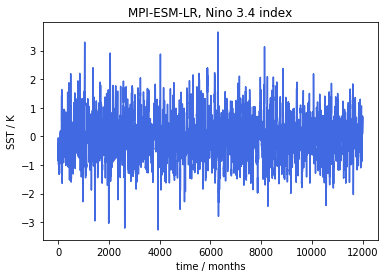

In [5]:
plt.figure(figsize=(6,4))

plt.plot(nino,'royalblue')
plt.xlabel('time / months'); plt.ylabel('SST / K')
plt.title('MPI-ESM-LR, Nino 3.4 index');

print variance

In [6]:
print('Variance of Nino3.4 index: ', np.var(nino))

Variance of Nino3.4 index:  0.5736622922895954


## Two different approaches to compute power spectrum

### Approach 1: compute periodogram via dft and smooth to obtain estimate of power spectrum

The power spectrum can be calculated from the squares of the coefficients of the discrete fourier transformation. Here, I am using rfft of numpy, which yields the discrete fourier transformation of a real time series. I also make use of the fact that there is an even number of months N, so that there are N/2+1 frequencies in the power spectrum. The first entry corresponds to the time mean (i.e., frequency zero), and is zero because the data was deseasonalized and detrended above. The last entry corresponds to a frquency of 0.5/month, i.e., the shortest oscillation that can be resolved.

I first calculate the periodogram:

In [7]:
def compute_periodogram(data):
    # periodram from a discrete Fourier transformation
    
    dft = np.fft.rfft(data)
    pdg = np.real(dft)**2 + np.imag(dft)**2  # periodogram in units of K**2/month
    frq = np.arange(0, pdg.size) / data.size # frequencies in 1/month, range from 0 to 0.5
    
    return pdg, frq

pdg, frq = compute_periodogram(nino)

Here is a plot of the periodogram. Note that it is not normalized, which is indicated by the y-axis aribitrary units (a.u.).

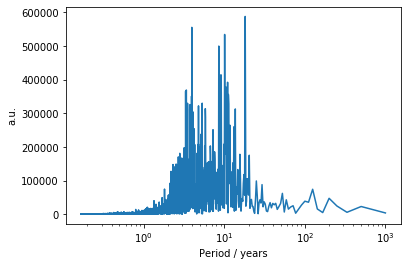

In [8]:
plt.semilogx(1/(12*frq[1:]), pdg[1:]);
plt.xlabel('Period / years');
plt.ylabel('a.u.');

The periodogram is quite noisy. Indeed, it is known that the peridogram is an unstable estimator of the power specttrum (short for power spectral density). One approach to this problem is to smooth the periodogram, e.g., by a running mean with a rectagular window. This is done below.

In [9]:
def periodogram2powerspectrum(pdg, frq, data, frq_wdw=None):
    # input: pdg: periodogram calculated above
    #        frq: frequencies of the periodogram
    #        data: time-series (detrended and deseasonalized), needed for variance and normalization
    #        frq_wdw: half frequency width of rectangular window for running mean
    
    # Step 1: smooth periodogram to obtain power spectrum
    # Step 2: normalize power spectrum so that its integral equals the variance of the time-series data
    
    # Step 1
    if frq_wdw is None: frq_wdw = 0.002 
    psp = np.zeros(pdg.size)    
    for i in range(0, psp.size):
        psp[i] = np.mean( pdg[(frq>frq[i]-frq_wdw) & 
                              (frq<frq[i]+frq_wdw)] )
    
    # Step 2
    dfrq = 1/data.size * np.ones(frq.size) # width of the frequency bands
    dfrq[0]  = 0.5 * 1/data.size # first and last frquency band have half the width
    dfrq[-1] = 0.5 * 1/data.size
    psp = psp * np.var(data) / np.sum(psp*dfrq)
    
    return psp

In [10]:
psp = periodogram2powerspectrum(pdg, frq, nino)

I now plot power spectrum. It is much smoother, and quite similar to Fig. 2a of Raedel et al. (2016, blue line).

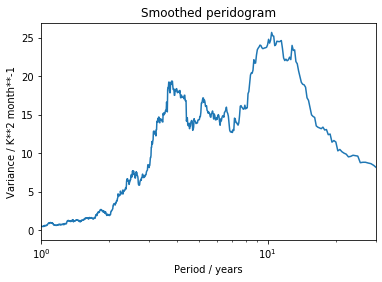

In [11]:
plt.figure(figsize=(6,4))
plt.semilogx(1/(12*frq[1:]), psp[1:]) # we ommit frequency zero to avoid a warning from semilogx
plt.xlim(1,30);
plt.xlabel('Period / years'); plt.ylabel('Variance / K**2 month**-1');
plt.title('Smoothed peridogram');

Still, the power spectrum shows what I believe are artifical small oscillations. These might be removed by some more advanced smoothing, e.g., by using a triangular window or the Daniell weighting. I therefore now also look at another approach: Welch's method. 

### Approach 2: Welch's method

Welch's method reduces the noise of the periodogram on the expense of resolution in the frequency domain. In a nutshell, it computes individual periodgrams over overlapping chunks of the time series and averages these to obtain a power spectrum.

I found this to work fine, and it is implemented into scipy.signal. There is of course a reduced frquency resolution, but that does not matter at all and he apparently higher resolution in approach 1 is misguiding anyway.

In [12]:
nyears=100 # use 100-year chunks of time series
from scipy import signal
frq2, psp2 = signal.spectral.welch(nino, nperseg=nyears*12)

Now plot the power spectrum that is produced by Welch's method. 

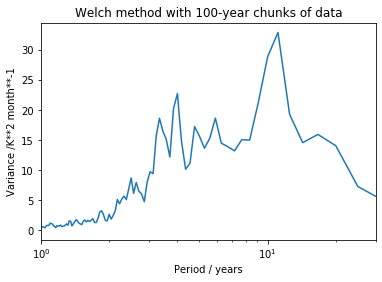

In [13]:
plt.figure(figsize=(6,4))
plt.semilogx(1/(12*frq2[1:]), psp2[1:]) # we ommit frequency zero to avoid a warning from semilogx
plt.xlim(1,30);
plt.xlabel('Period / years'); plt.ylabel('Variance /K**2 month**-1');
plt.title('Welch method with 100-year chunks of data');

## Summary

Both approaches work. But approach #2 is easier to use and yields less noisy results.